In [1]:
import sys
import h5py
import glob
import numpy as np 
from numpy import random
import matplotlib.pyplot as plt
from scipy import signal
import scipy as sp
from scipy.signal import butter
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel
import time
import random

In [2]:
# reading h5 file
f = h5py.File("20190518_173944_projection-Copy1.h5")
list(f.keys())
shots = f.get("n-shots")
photE = f.get("x-axis")
intense = f.get("y-axis")
spectrum = range(0,len(intense[1,:]-1)) # for parameter redefinition
x = np.asarray(spectrum)

In [36]:
# Peak finding parameters
heightcut = 10 # percentage height of max a peak must be
prominence = 10 # percentage prominence required for peak

In [4]:
# Lowpass/backloop conditions
deg = 5 # lowpass function degree. Chosen by inspection.
threshold = 10 # percentage overlap threshold for spectra to be sent through slow fit
backloop_condition_slow = 5
backloop_condition = 8 # percentage height difference between max of raw and max of lp function (maybe determine in terms of noise)

In [ ]:
# 3_stage_phase_3 & 4 - check first
#avg spectra 
# 2 stage linac one : narrower spike width

Optimising lowpass cutoff for fast fit
Trialled for spectrum 18
Trialled for spectrum 2
Trialled for spectrum 20
Trialled for spectrum 78
Average cutoff for dataset: 0.0110
Time taken for fast fit: 0.16862265268961588 minutes
Number of spectra to be analysed by slow fit:  11
Beginning slow fit


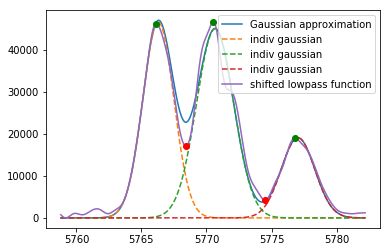

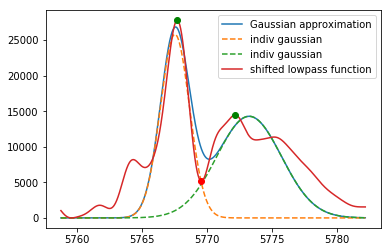

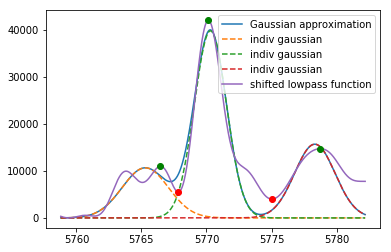

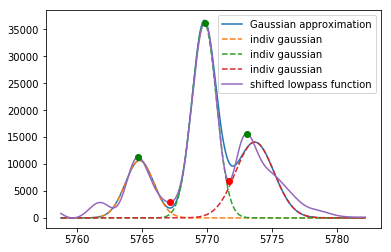

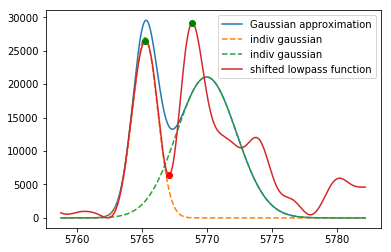

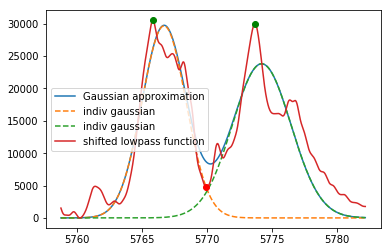

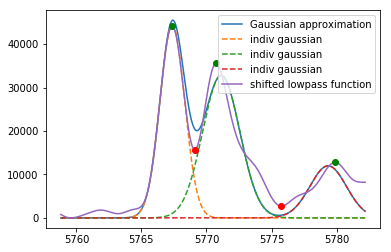

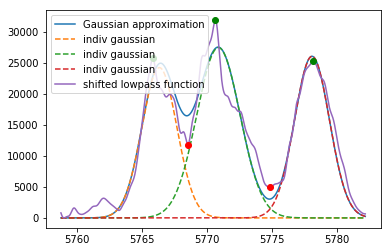

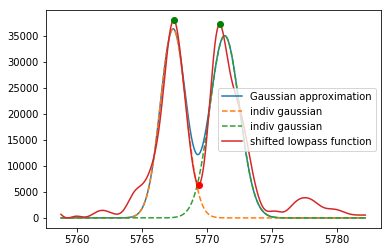

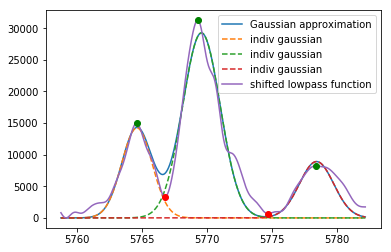

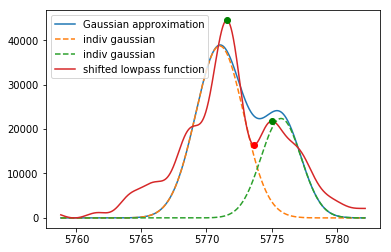

Data replaced
Time taken for slow fit: 0.09176077842712402 minutes
Time taken overall: 0.2603834311167399 minutes


In [37]:
start = time.time()
print("Optimising lowpass cutoff for fast fit")
cutoff = Fast_Backloop().cutoff()
spectra_for_slow_fit = []
for i in range(len(intense[:,1])):
    fn = Fast_Fit(intense[i,:],deg,cutoff)
    if fn.U() == 1:
        spectra_for_slow_fit = np.append(spectra_for_slow_fit, i) 
    
    if i == 0:
        lpfns = fn.lpfn
        gaussians = fn.gauss()
        number_of_peaks = fn.nofpeaks()
        avgsigma = fn.avg_sigmas()
    else:
        lpfns = np.vstack((lpfns, fn.lpfn))
        gaussians = np.vstack((gaussians, fn.gauss()))
        number_of_peaks = np.vstack((number_of_peaks, fn.nofpeaks()))
        avgsigma = np.vstack((avgsigma, fn.avg_sigmas()))

intermediate = time.time()
print("Time taken for fast fit:", (intermediate - start)/60, "minutes")
print("Number of spectra to be analysed by slow fit: ", len(spectra_for_slow_fit))
print("Beginning slow fit")

for k in spectra_for_slow_fit:
    k = int(k)
    fn = Slow_Fit(intense[k,:])
    lpfns[k] = fn.lpfn
    gaussians[k] = fn.gauss()
    number_of_peaks[k] = fn.nofpeaks()
    avgsigma[k] = fn.avg_sigmas()
print("Data replaced")
end = time.time()
print("Time taken for slow fit:", (end - intermediate)/60, "minutes")
print("Time taken overall:", (end - start)/60, "minutes")

In [656]:
corr = (max(photE)-min(photE))/len(intense[1,:])

# Number of peaks analysis
avg = np.average(number_of_peaks)
print("Average number of peaks:",avg)
avg2 = np.average(avgsigma)*corr
print("Average sigma of all peaks:",avg2)

Average number of peaks: 2.48
Average sigma of all peaks: 1.4497732460223216


In [673]:
avg_sigmas = [0, 0, 0, 0, 0, 0, 0, 0]
counts = [0, 0, 0, 0, 0, 0, 0, 0]
for i in range(len(number_of_peaks)):
    index = int(number_of_peaks[i])
    counts[index] = counts[index] + 1
    
    avg_sigmas[index] = avg_sigmas[index] + avgsigma[index]*corr

for i in range(len(avg_sigmas)):
    if counts[i] == 0:
        avg_sigmas[i] = 0
    else:
        avg_sigmas[i] = avg_sigmas[i]/counts[i]

In [682]:
for i in range(1,len(avg_sigmas)):
    print ("Number of spectra with", i, "peaks:",counts[i])
    print ("Average sigma for spectra with",i,"number of peaks:", avg_sigmas[i])
    print(" ")

Number of spectra with 1 peaks: 12
Average sigma for spectra with 1 number of peaks: [1.25395977]
 
Number of spectra with 2 peaks: 38
Average sigma for spectra with 2 number of peaks: [3.01016318]
 
Number of spectra with 3 peaks: 42
Average sigma for spectra with 3 number of peaks: [0.92587855]
 
Number of spectra with 4 peaks: 7
Average sigma for spectra with 4 number of peaks: [1.76401345]
 
Number of spectra with 5 peaks: 0
Average sigma for spectra with 5 number of peaks: 0
 
Number of spectra with 6 peaks: 1
Average sigma for spectra with 6 number of peaks: [1.29597875]
 
Number of spectra with 7 peaks: 0
Average sigma for spectra with 7 number of peaks: 0
 


In [5]:
class Slow_Fit:
    def __init__(self, lowpassdata):
        self.lowpassdata = lowpassdata
        
        # fitting lowpass, including backloop for better cutoff.
        lpcutoff = 0.0001
        while True:
            # fitting lowpass function with given cutoff
            b, a = signal.butter(deg, lpcutoff, 'low')
            self.spec = signal.filtfilt(b, a, self.lowpassdata)
                
            # Visual module for checking
            """plt.plot(self.lpfn, label='lowpass')
            plt.plot(self.lowpassdata, label='raw data')
            plt.legend()
            plt.show()"""

            # condition for good fitting based on vertical distance between maxima of raw and lowpass dataset
            # if not fitted within backloop_condition, increment until good fit
            self.height_difference = abs(max(self.lowpassdata) - max(self.spec))
            if self.height_difference > backloop_condition_slow * max(self.lowpassdata)/100:
                lpcutoff = lpcutoff + 0.001
            else:
                break
        
        # shift spectrum
        self.lpfn = self.spec - min(self.spec)
        
        # calculate noise
        self.noise = np.array([self.lowpassdata-self.spec]).T
        
        # Extracting peaks ([x-axis, y-axis]) - indexed to neutral
        self.peaks = Peakfinder(self.lpfn).peaks
        
        # Apply further constraints to peaks
        self.filteredpeaks = Filter_peaks(self.peaks).filtered_peaks()
                
        # number of peaks, after filtering.
        self.n = len(self.filteredpeaks)
        
        fn = Slice(self.lpfn,self.filteredpeaks, self.n)
        
        # Slice into individual peak functions, outside peak spectrum = 0. 
        self.slices = fn.slices()
        
        # Approximate slices with Gaussians
        
        self.fn1 = Gauss(self.slices, self.n)
        self.Gaussian = self.fn1.Added_Gaussian()  
        self.IndivGauss = self.fn1.IndivGaussians()
        
        slicepos = fn.SlicingPoints()
        
        self.fn2 = MaxMin(self.IndivGauss,self.n, slicepos, self.lpfn)
        
        plt.plot(photE, self.Gaussian, label="Gaussian approximation")
        for i in range(self.IndivGauss.shape[0]):
            plt.plot(photE, self.IndivGauss[i],'--',markersize = 0.1, label="indiv gaussian")
        plt.plot(photE, self.lpfn, label = "shifted lowpass function")
        
        plt.plot(self.fn2.GetMax_x(),self.fn2.GetMax_y(), 'go')
        if self.n != 1:
            plt.plot(self.fn2.GetMin_x(),self.fn2.GetMin_y(), 'ro')
        plt.legend()
        plt.show()
        
        minima = fn.SlicingPoints()
        self.u = 0
        for i in range(len(minima)):
            index = int(minima[i])
            if (abs(self.Gaussian[index]-self.lpfn[index])*100/max(self.lpfn)) > threshold and self.u == 0:
                self.u = self.u + 1
        
        sig = self.fn1.sigmas
        self.sig = np.array((np.average(sig)))
        
    def U(self):
        return self.u
    def lpfn(self):
        return self.lpfn
    def gauss(self):
        return self.Gaussian
    def indiv(self):
        return self.IndivGauss
    def nofpeaks(self):
        return self.n
    def avg_sigmas(self):
        return self.sig

In [34]:
class MaxMin:
    def __init__(self, data, nofpeaks, slicepos, lpfn):
        self.n = nofpeaks
        self.data = data
        self.slicepos = slicepos
        self.lpfn = lpfn
        
        if self.n == 1:
            self.ymax = max(self.data)
            self.xmax = np.where(self.data == self.ymax)
            
        else:
            self.ymin = []
            self.xmin = []
            for j in range(len(slicepos)):
                ind2 = int(self.slicepos[j])
                ymin = self.lpfn[ind2]
                self.ymin = np.append(self.ymin, ymin)

                xmin = photE[self.slicepos[j]]
                self.xmin = np.append(self.xmin, xmin)
                
            self.ymax = []
            self.xmax = []
            for i in range(self.n):
                if i == 0:
                    i1 = int(0)
                    i2 = int(self.slicepos[i])
                    ymax = max(self.lpfn[i1:i2])
                    xmax = np.where(self.lpfn == ymax)

                    ind1 = int(xmax[0])
                    xmax = photE[ind1]
                    self.ymax = np.append(self.ymax, ymax)
                    self.xmax = np.append(self.xmax, xmax)
                    
                elif i == self.n - 1:
                    i1 = int(self.slicepos[i-1])
                    i2 = int(len(self.lpfn))
                    ymax = max(self.lpfn[i1:i2])
                    xmax = np.where(self.lpfn == ymax)

                    ind1 = int(xmax[0])
                    xmax = photE[ind1]
                    self.ymax = np.append(self.ymax, ymax)
                    self.xmax = np.append(self.xmax, xmax)
                    
                else:
                    i1 = int(self.slicepos[i-1])
                    i2 = int(self.slicepos[i])

                    ymax = max(lpfn[i1:i2])
                    xmax = np.where(lpfn == ymax)

                    ind1 = int(xmax[0])
                    xmax = photE[ind1]
                    self.ymax = np.append(self.ymax, ymax)
                    self.xmax = np.append(self.xmax, xmax)

    def GetMax_x(self):
        return self.xmax
    def GetMax_y(self):
        return self.ymax
    def GetMin_x(self):
        return self.xmin
    def GetMin_y(self):
        return self.ymin            

In [7]:
class Fast_Fit:
    def __init__(self, lowpassdata, deg, cutoff):
        self.cutoff = float(cutoff)
        # lowpass function itself
        self.lowpassdata = lowpassdata
        b, a = signal.butter(deg, self.cutoff, 'low')
        self.spec = signal.filtfilt(b, a, self.lowpassdata)
        
        # shift spectrum
        self.lpfn = self.spec - min(self.spec)
        
        # calculate noise
        self.noise = np.array([self.lowpassdata-self.spec]).T
        
        """
        # visual module
        print("plotting lowpass data vs raw data, noise etc")
        plt.plot(photE,self.lowpassdata,label="raw data")
        plt.plot(photE,self.lpfn,label="shifted spectrum")
        plt.plot(photE,self.spec,label="lowpass")
        plt.plot(photE,self.noise,label="noise")
        plt.legend()
        plt.show()
        """
        
        # Extracting peaks ([x-axis, y-axis]) - indexed to neutral
        self.peaks = Peakfinder(self.lpfn).peaks
        
        # Apply further constraints to peaks
        self.filteredpeaks = Filter_peaks(self.peaks).filtered_peaks()
                
        # number of peaks, after filtering.
        self.n = len(self.filteredpeaks)
        
        fn = Slice(self.lpfn,self.filteredpeaks, self.n)
        
        # Slice into individual peak functions, outside peak spectrum = 0. 
        self.slices = fn.slices()
        
        # Approximate slices with Gaussians
        
        self.fn1 = Gauss(self.slices, self.n)
        self.Gaussian = self.fn1.Added_Gaussian()  
        self.IndivGauss = self.fn1.IndivGaussians()
        
        """
        # Visual module: comparing Gaussian to lowpass function - including individual gaussians
        plt.plot(self.Gaussian, label = "Added Gaussian")
        plt.plot(self.lpfn, label = "Shifted lowpass")
        for i in range(self.IndivGauss.shape[0]):
            plt.plot(self.IndivGauss[i],'--', markersize = '0.1', label = "indiv gaussian")
        plt.legend()
        plt.show()
        #"""
        
        minima = fn.SlicingPoints()
        self.u = 0
        for i in range(len(minima)):
            index = int(minima[i])
            if (abs(self.Gaussian[index]-self.lpfn[index])*100/max(self.lpfn)) > threshold and self.u == 0:
                self.u = self.u + 1
                
        sig = self.fn1.sigmas
        self.sig = np.array((np.average(sig)))
                
    def U(self):
        return self.u
    def lpfn(self):
        return self.lpfn
    def gauss(self):
        return self.Gaussian
    def indiv(self):
        return self.IndivGauss
    def nofpeaks(self):
        return self.n
    def avg_sigmas(self):
        return self.sig

In [8]:
class Gauss:
    def __init__(self, data, n):
        self.data = data
        self.sigmas = []
        self.n = n
        
        if self.n == 1:
            peak = self.data
            mod = GaussianModel()
            pars = mod.guess(peak, x = x)
            out = mod.fit(peak, pars, x= x)
            gaussResult = out.best_fit
            self.gaussResults = gaussResult
            self.sigmas.append(out.params['sigma'].value)
        
        else:
            for i in range(len(self.data)):
                peak = self.data[i,:]
                mod = GaussianModel()
                pars = mod.guess(peak, x = x)
                out = mod.fit(peak, pars, x= x)
                gaussResult = out.best_fit

                # stacking Gaussians
                if i == 0:
                    self.gaussResults = gaussResult
                else:
                    self.gaussResults = np.vstack((self.gaussResults,gaussResult))

                self.sigmas.append(out.params['sigma'].value)
        
    def IndivGaussians(self):
        return self.gaussResults
        
    def sigmas(self):
        return self.sigmas
        
    def Added_Gaussian(self):
        if self.n == 1:
            GaussAdd = self.gaussResults
            
        else:
            GaussAdd = []
            for o in range(len(self.gaussResults[1])):
                GaussAdd = np.append(GaussAdd, 0)
                for t in range(len(self.gaussResults[:,1])):
                    GaussAdd[o] = GaussAdd[o] + self.gaussResults[t,o]
                    
        return GaussAdd

In [9]:
class Slice:
    def __init__(self, data, peaks, nofpeaks):
        self.peaks = peaks
        self.data = data
        self.xpeaks = peaks 
        self.minima = []
        self.nofpeaks = nofpeaks
        for j in range(self.nofpeaks-1):
            # Compute x-indices of all minima by which we slice
            peak1 = self.xpeaks[j]
            peak2 = self.xpeaks[j+1]
            Min_y = min(data[peak1:peak2])
            Min_x = np.asarray(np.where(self.data == Min_y))
            self.minima = np.append(self.minima, Min_x)      
    
        # To make following loop easier, include zeroth and last index of spectrum
        zero = np.insert(self.minima, 0, 0)
        self.minima_indices = np.append(zero, len(self.data))
        
        # Actually slicing, filling zeros where out of slice bounds
        for k in range(self.nofpeaks):
            if k == 0:
                index0 = self.minima_indices[k]
                index1 = self.xpeaks[k]/2
                index2 = self.minima_indices[k+1]
                single_slice = self.data[int(index1):int(index2)]
                for n in range(int(index0),int(index1)):
                    single_slice = np.insert(single_slice, 0, 0)
                for n in range(int(index2), len(self.data)):
                    single_slice = np.append(single_slice, 0)
                self.Slices = single_slice
                
            elif k == len(self.peaks)-1:
                index1 = self.minima_indices[k]
                index2 = self.xpeaks[k] + (len(self.data)-self.xpeaks[k])/2
                index0 = self.minima_indices[k+1]
                single_slice = self.data[int(index1):int(index2)]  
                for n in range(0,int(index1)):
                    single_slice = np.insert(single_slice, 0, 0)   
                for n in range(int(index2), int(index0)):
                    single_slice = np.append(single_slice, 0)  
                self.Slices = np.vstack((self.Slices,single_slice))
                
            else:
                single_slice = self.data[int(self.minima_indices[k]):int(self.minima_indices[k+1])]
                for n in range(0,int(self.minima_indices[k])):
                    single_slice = np.insert(single_slice, 0, 0)
                for n in range(int(self.minima_indices[k+1]), len(self.data)):
                    single_slice = np.append(single_slice, 0)
                self.Slices = np.vstack((self.Slices,single_slice))
            """
            # Visual module
            print("plotting single slices")
            plt.plot(single_slice)
            plt.show()
            """
        
    def SlicingPoints(self):
        return self.minima
    def slices(self):
        return self.Slices

In [10]:
# helps fast_fit return peaks
class Peakfinder:
    def __init__(self, data):
        self.data = data
        self.peaks = sp.signal.find_peaks(self.data, height = heightcut, prominence = prominence*max(self.data)/100)
        self.peaks = self.peaks[0]
        
        self.xpeaks = np.asarray(self.peaks)
        self.ypeaks = np.asarray(self.data[self.xpeaks])
        self.allpeaks = np.array([self.xpeaks,self.ypeaks])
        
        
    def peaks(self):
    # returns dataset with neutral index x and intensity y  
        """
        # Visual module
        print("Plotting peaks found. Neutrally indexed.")
        plt.plot(self.data, label="data fed to peak finder")
        plt.plot(self.xpeaks,self.ypeaks,label="peaks",'go')
        plt.legend()
        plt.show()
        """
        return self.allpeaks

In [11]:
# Can put further constraints in this class
class Filter_peaks:
    def __init__(self,data):
        self.data = data
        return None
    def filtered_peaks(self):
        return self.data

In [12]:
# Trialling lowpass function for random spectra to find optimal cutoff
# Indexed neutrally (i.e. not by energy)

# Potential upgrades: fit also "from above" -> i.e. take into account overfitting. Eg by max threshold of peaks
# Could also incorporate backloop into slowfit!

class Fast_Backloop:
    def __init__(self):
        cutoffs = []
        
        # finding appropriate cutoff for 4 spectra within dataset
        for i in range(4):

            p = random.randrange(0, len(intense[:,1]), 1) # finding random spectrum to use
            
            print ("Trialled for spectrum", p)
            
            self.lowpassdata = intense[p,:]
            lpcutoff = 0.001                         # this constant seems low enough - reconsider if not applicable to all datasets
            n = 0

            while True:
                # fitting lowpass function with given cutoff
                b, a = signal.butter(deg, lpcutoff, 'low')
                self.lpfn = signal.filtfilt(b, a, self.lowpassdata)
                
                # Visual module for checking
                """plt.plot(self.lpfn, label='lowpass')
                plt.plot(self.lowpassdata, label='raw data')
                plt.legend()
                plt.show()"""

                # condition for good fitting based on vertical distance between maxima of raw and lowpass dataset
                # if not fitted within backloop_condition, increment until good fit
                self.height_difference = abs(max(self.lowpassdata) - max(self.lpfn))
                if self.height_difference > backloop_condition * max(self.lowpassdata)/100:
                    lpcutoff = lpcutoff + 0.005
                else:
                    break

            cutoffs = np.append(cutoffs, lpcutoff)
        
        # Finding average of cutoffs to 4 decimal points
        self.avg_cutoff = "%.4f" % np.average(cutoffs)
        print("Average cutoff for dataset:", self.avg_cutoff)
        return None
    def cutoff(self):
        return self.avg_cutoff